Imports

In [1]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import numpy as np
import pandas as pd
import time

Using TensorFlow backend.


In [2]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

### Initial Preprocessing

In [3]:
from pandas import read_csv
data = pd.read_csv('../data/UCI_2010_2014.csv')
data = data.drop('No', axis=1, inplace=False)

In [4]:
data = data.drop(['year','month','day','hour'], axis=1, inplace=False)

In [5]:
data.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']

In [6]:
# mark all NA values with 0
data['pollution'].fillna(0, inplace=True)
# drop the first 24 hours
data = data[24:]
# summarize first 5 rows
print(data.head(5))
# save to file
#data.to_csv('pollution.csv')

    pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
24      129.0  -16  -4.0  1020.0      SE     1.79     0     0
25      148.0  -15  -4.0  1020.0      SE     2.68     0     0
26      159.0  -11  -5.0  1021.0      SE     3.57     0     0
27      181.0   -7  -5.0  1022.0      SE     5.36     1     0
28      138.0   -7  -5.0  1022.0      SE     6.25     2     0


## Baseline LSTM + room to change network architecture

In [12]:
# load dataset
dataset = pd.read_csv('../data/pollution.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features (after I reframe into a supervised learning problem)
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaled = scaler.fit_transform(values)
# frame as supervised learning -
####### Can change t_input timesteps here ##########  ### I changed it to time lag = 4
reframed = series_to_supervised(values, 48, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[-7,-6,-5,-4,-3,-2,-1]], axis=1, inplace=True)
print(reframed.head())

# split into train and test sets
values = reframed.values
#values = scaled
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(values[:,:-1])
scaled_label = scaler.fit_transform(values[:,-1].reshape(-1,1))
values = np.column_stack((scaled_features, scaled_label))

n_train_hours = 365 * 24 * 4
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
# features take all values except the var1
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
#print(scaled)
# design network
model = Sequential()
model.add(LSTM(128, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(50, activation='tanh'))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

    var1(t-48)  var2(t-48)  var3(t-48)  var4(t-48)  var5(t-48)  var6(t-48)  \
48       129.0       -16.0        -4.0      1020.0         2.0        1.79   
49       148.0       -15.0        -4.0      1020.0         2.0        2.68   
50       159.0       -11.0        -5.0      1021.0         2.0        3.57   
51       181.0        -7.0        -5.0      1022.0         2.0        5.36   
52       138.0        -7.0        -5.0      1022.0         2.0        6.25   

    var7(t-48)  var8(t-48)  var1(t-47)  var2(t-47)   ...     var8(t-2)  \
48         0.0         0.0       148.0       -15.0   ...           0.0   
49         0.0         0.0       159.0       -11.0   ...           0.0   
50         0.0         0.0       181.0        -7.0   ...           0.0   
51         1.0         0.0       138.0        -7.0   ...           0.0   
52         2.0         0.0       109.0        -7.0   ...           0.0   

    var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
48       73.0 

In [13]:
print(reframed.head())

    var1(t-48)  var2(t-48)  var3(t-48)  var4(t-48)  var5(t-48)  var6(t-48)  \
48       129.0       -16.0        -4.0      1020.0         2.0        1.79   
49       148.0       -15.0        -4.0      1020.0         2.0        2.68   
50       159.0       -11.0        -5.0      1021.0         2.0        3.57   
51       181.0        -7.0        -5.0      1022.0         2.0        5.36   
52       138.0        -7.0        -5.0      1022.0         2.0        6.25   

    var7(t-48)  var8(t-48)  var1(t-47)  var2(t-47)   ...     var8(t-2)  \
48         0.0         0.0       148.0       -15.0   ...           0.0   
49         0.0         0.0       159.0       -11.0   ...           0.0   
50         0.0         0.0       181.0        -7.0   ...           0.0   
51         1.0         0.0       138.0        -7.0   ...           0.0   
52         2.0         0.0       109.0        -7.0   ...           0.0   

    var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
48       73.0 

Train on 35040 samples, validate on 8712 samples
Epoch 1/25
35040/35040 [==============================] - 5s 144us/step - loss: 0.0464 - val_loss: 0.0277
Epoch 2/25
35040/35040 [==============================] - 4s 106us/step - loss: 0.0317 - val_loss: 0.0273
Epoch 3/25
35040/35040 [==============================] - 4s 102us/step - loss: 0.0278 - val_loss: 0.0268
Epoch 4/25
35040/35040 [==============================] - 4s 111us/step - loss: 0.0266 - val_loss: 0.0326
Epoch 5/25
35040/35040 [==============================] - 4s 110us/step - loss: 0.0258 - val_loss: 0.0382
Epoch 6/25
35040/35040 [==============================] - 4s 113us/step - loss: 0.0254 - val_loss: 0.0232
Epoch 7/25
35040/35040 [==============================] - 4s 121us/step - loss: 0.0217 - val_loss: 0.0231
Epoch 8/25
35040/35040 [==============================] - 4s 118us/step - loss: 0.0236 - val_loss: 0.0242
Epoch 9/25
35040/35040 [==============================] - 4s 115us/step - loss: 0.0217 - val_loss: 0.02

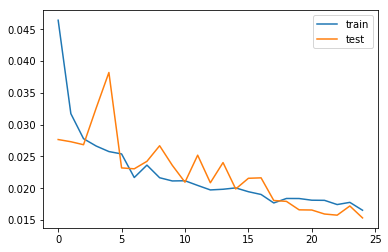

This took 102.48315596580505 seconds.
Test RMSE: 25.654


In [14]:
start = time.time()

# fit network
###################### Can change Epochs, Batch size here #######################
history = model.fit(train_X, train_y, epochs=25, batch_size=72, validation_data=(test_X, test_y), 
                    verbose=1, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
 
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
end = time.time()
print('This took {} seconds.'.format(end - start))
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE of 25.654

In [18]:
from matplotlib import pyplot as plt

In [26]:
def plot_predicted(predicted_data, true_data):
    fig, ax = plt.subplots(figsize=(17,8))
    ax.set_title('Prediction vs. Actual after 100 epochs of training')
    ax.plot(true_data, label='True Data', color='green', linewidth='3')

    ax.plot(predicted_data, label='Prediction', color='red', linewidth='2')
    plt.legend()
    plt.show()

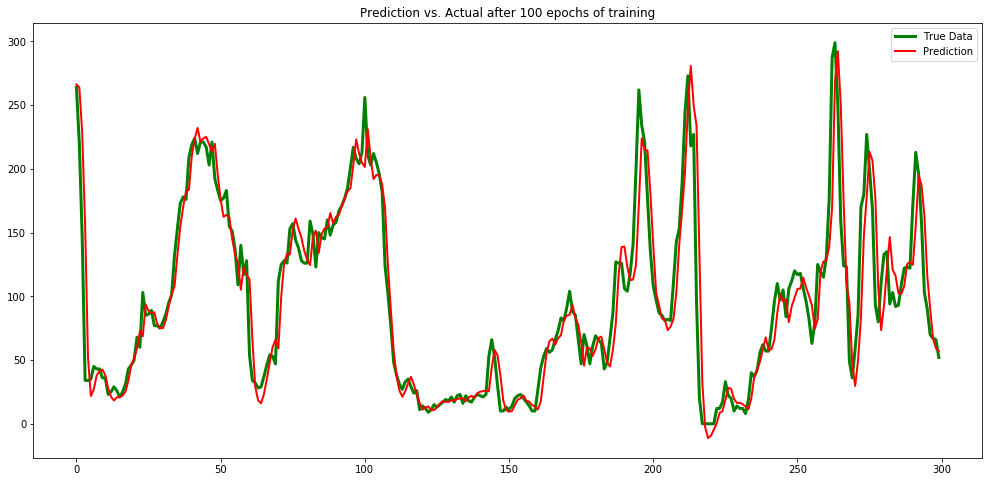

In [27]:
plot_predicted(inv_yhat[:300,], inv_y[:300,])